In [1]:
import cv2
import torch

def align_images(img1, img2):
  # Convert the pytorch tensors to numpy arrays
  img1 = img1.numpy().transpose(1, 2, 0)
  img2 = img2.numpy().transpose(1, 2, 0)

  # Convert the images to grayscale
  gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

  # Normalize the images to 8-bit unsigned integers
  gray1 = cv2.normalize(gray1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
  gray2 = cv2.normalize(gray2, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

  # Create a sift object
  sift = cv2.SIFT_create()

  # Find the keypoints and descriptors with sift
  kp1, des1 = sift.detectAndCompute(gray1, None)
  kp2, des2 = sift.detectAndCompute(gray2, None)

  # Create a brute force matcher object
  bf = cv2.BFMatcher()

  # Match the descriptors
  matches = bf.knnMatch(des1, des2, k=2)

  # Apply ratio test to filter out the good matches
  good = []
  for m, n in matches:
    if m.distance < 0.75 * n.distance:
      good.append(m)

  # Find the homography matrix that maps the keypoints from img1 to img2
  src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
  dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
  
  H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)

  # Warp img1 to align with img2 using the homography matrix
  h, w = img1.shape[:2]
  aligned_img1 = cv2.warpPerspective(img1, H, (w, h))

  # Convert the aligned image back to a pytorch tensor
  aligned_img1 = torch.from_numpy(aligned_img1.transpose(2, 0, 1))

  return aligned_img1


target shape and type: torch.Size([3, 1344, 1008]), torch.float32


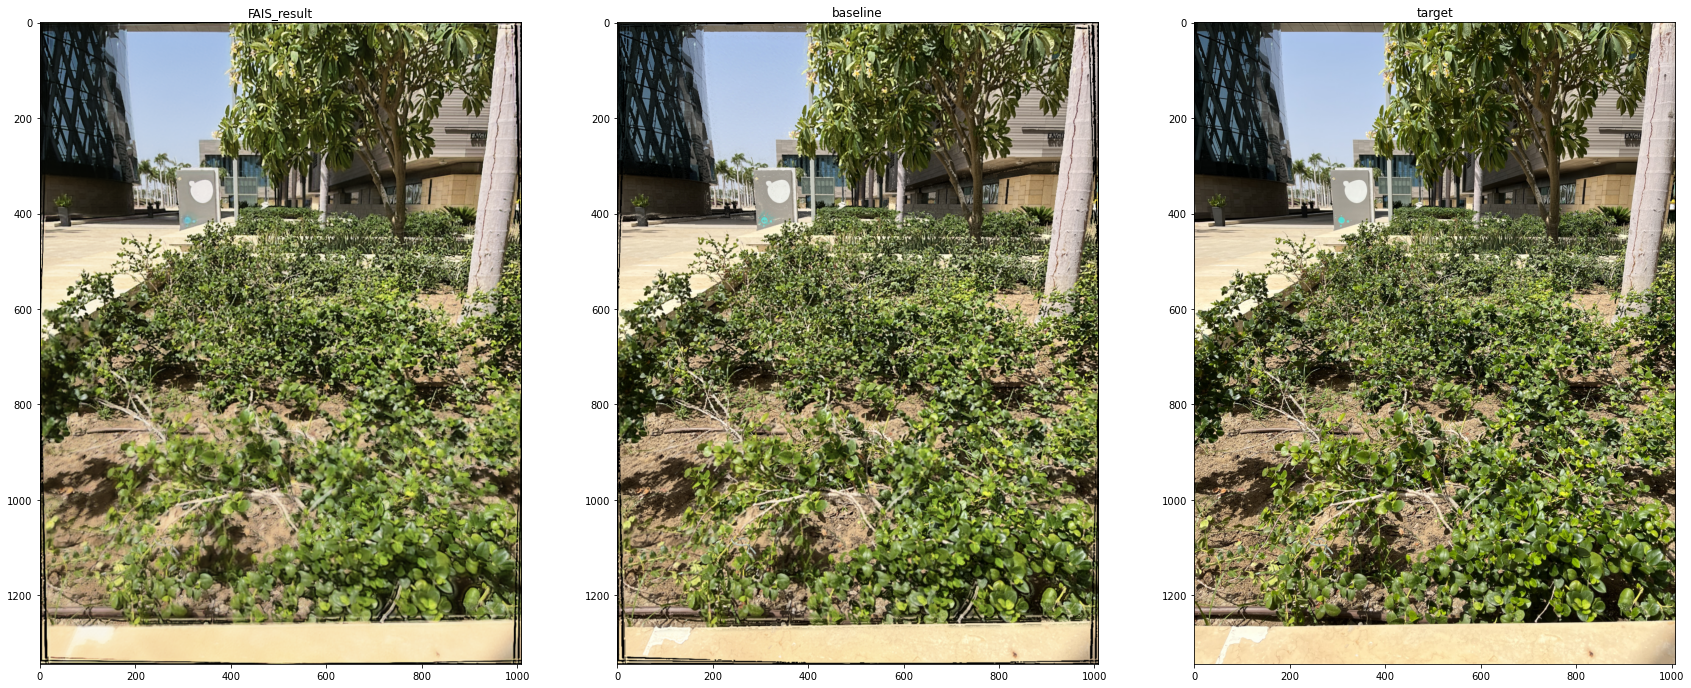

Lower is better (MSE)
FAIS: 0.0147078987210989
baseline: 0.015533078461885452
Higher is better (PSNR)
FAIS: 66.4552993774414
baseline: 66.21823120117188


In [2]:

import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor

# method
method = 'MS_1_jitter'
depth = True

# # load output of FIAS method from output/3Dset/ folder
# FAIS_result = torchvision.io.read_image(f'output/{method}/FAIS_result.png')
# baseline = torchvision.io.read_image(f'output/{method}/resize_beseline_result.png')
# Z_Stacked_PMax = torchvision.io.read_image(f'output/Zerene_stacked/{method}_PMax.jpg')
# Z_Stacked_DMap = torchvision.io.read_image(f'output/Zerene_stacked/{method}_PMax.jpg')
# target = torchvision.io.read_image(f'input/{method}/GT/GT.png')

# load output of FAIS method from output/3Dset/ folder using Image
FAIS_result = Image.open(f'output/{method}/FAIS_result.png')
baseline = Image.open(f'output/{method}/resize_beseline_result.png')
target = Image.open(f'input/{method}/GT/GT.JPEG')

FAIS_result = ToTensor()(FAIS_result)
baseline = ToTensor()(baseline)
target = ToTensor()(target)

if depth:
    # remove the alpha channel from target
    target = target[:3, :, :]

# resize the target to match the size of FAIS_result and baseline
target = torchvision.transforms.functional.resize(target, (FAIS_result.shape[1], FAIS_result.shape[2]))

# print the shape and type of target image
print(f'target shape and type: {target.shape}, {target.dtype}')

baseline = align_images(baseline, target)
FAIS_result = align_images(FAIS_result, target)

# save the cropped version of Z_Stacked_PMax and DMap
torchvision.utils.save_image(target, f'output/{method}/target_cropped.png')

# display FAIS_result, baseline, Z_Stacked_PMax and DMap, and target images
plt.figure(figsize=(50, 50))
plt.subplot(1, 5, 1)
plt.imshow(FAIS_result.permute(1, 2, 0))
plt.title('FAIS_result')
plt.subplot(1, 5, 2)
plt.imshow(baseline.permute(1, 2, 0))
plt.title('baseline')
plt.subplot(1, 5, 3)
plt.imshow(target.permute(1, 2, 0))
plt.title('target')
plt.savefig(f'output/{method}/comparison.png')
plt.show()


# create a criterion that measures MSE loss
criterion = nn.MSELoss()

# print input and target types
FAIS_result, baseline, target = FAIS_result.float(), baseline.float(), target.float()
# compute the MSE loss
FAIS_mse = criterion(FAIS_result, target)
FAIS_psnr = 10 * np.log10(255**2 / FAIS_mse)
baseline_mse = criterion(baseline, target)
baseline_psnr = 10 * np.log10(255**2 / baseline_mse)

print("Lower is better (MSE)")
print(f"FAIS: {FAIS_mse}")
print(f"baseline: {baseline_mse}")

print("Higher is better (PSNR)")
print(f"FAIS: {FAIS_psnr}")
print(f"baseline: {baseline_psnr}")



# save all mse and psnr values to a file
with open(f'output/{method}/mse_psnr.txt', 'w') as f:
    f.write(f"Lower is better (MSE)\n")
    f.write(f"FAIS: {FAIS_mse}\n")
    f.write(f"baseline: {baseline_mse}\n")
    f.write(f"\n")
    f.write(f"Higher is better (PSNR)\n")
    f.write(f"FAIS: {FAIS_psnr}\n")
    f.write(f"baseline: {baseline_psnr}\n")